In [1]:
import os, types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from botocore.client import Config
import ibm_boto3
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

import pandas as pd

calendar = pd.read_csv(wslib.mount.get_data_path('calendar.csv'))
calendar.head()

listings = pd.read_csv(wslib.mount.get_data_path('listings.csv'))
listings.head()


reviews = pd.read_csv(wslib.mount.get_data_path('reviews.csv'))
reviews.head()

calendar.shape, listings.shape, reviews.shape

((1308890, 4), (3585, 95), (68275, 6))

# Business Application Questions

Predict Price of Airbnb rentals.

The idea is to help new Airbnb host with listing their properties at a competitive price that will result in consistant bookings. 

- Does location determine how much a airbnb rental is listed for?
- Can the size (number of bedrooms, bathrooms, and bed) influnece higher price?
- Does higher review scores drive pricing?

# Data Exploration/Cleaning

## Calendar

In [2]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [3]:
calendar.isna().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

In [4]:
print("Percent of rows missing a price:  " + str(calendar.price.isna().sum()/calendar.shape[0]*100))

Percent of rows missing a price:  50.87157820748879


In [5]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [6]:
calendar.listing_id = calendar.listing_id.astype(str)

In [7]:
calendar.nunique()

listing_id    3585
date           365
available        2
price         1246
dtype: int64

In [8]:
calendar.available.value_counts()

f    665853
t    643037
Name: available, dtype: int64

In [9]:
calendar.listing_id.value_counts()

12898806    730
1340290     365
10153536    365
12253029    365
6992859     365
           ... 
2848393     365
13546414    365
1884045     365
777903      365
13524454    365
Name: listing_id, Length: 3585, dtype: int64

In [10]:
calendar.available.value_counts(True)

f    0.508716
t    0.491284
Name: available, dtype: float64

In [11]:
calendar[calendar.available == 'f'].isna().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

In [12]:
calendar[calendar.available == 'f'].shape

(665853, 4)

In [13]:
calendar.dropna(subset=['price'], inplace=True)

In [14]:
calendar.isna().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [15]:
calendar.shape

(643037, 4)

In [16]:
calendar.price = calendar.price.str.replace('$', '')
calendar.price = calendar.price.str.replace(',', '')
calendar.price = calendar.price.astype(float)

<ipython-input-16-78a52f071d64>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  calendar.price = calendar.price.str.replace('$', '')


In [17]:
calendar.price.describe(), calendar.price.median(), calendar.price.mode()

(count    643037.000000
 mean        198.438909
 std         180.142913
 min          11.000000
 25%          85.000000
 50%         150.000000
 75%         255.000000
 max        7163.000000
 Name: price, dtype: float64,
 150.0,
 0    150.0
 dtype: float64)

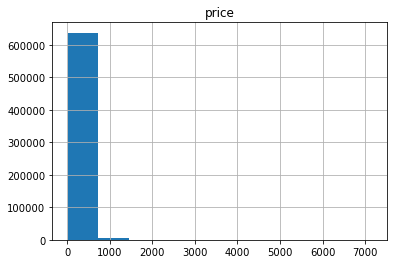

In [18]:
calendar.hist();

<AxesSubplot:>

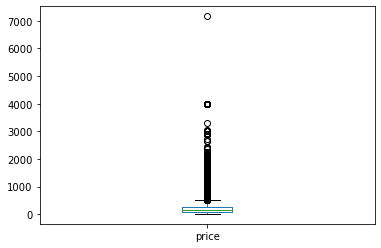

In [19]:
calendar.price.plot(kind='box')

### Cleaning
- converted listing id column to string
- dropped rows with missing price
- converted price to float

### Findings
- When listing is not available price will not be available as well
- 50% of the price data is not available
- Average price per night is 198.00
- Both median and mode price per night is 150.00
- Outlier price of 7163.00 is noted and will be considered for further evaluation


## Listing

In [20]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [21]:
listings.shape

(3585, 95)

In [22]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [23]:
#change id columns from ints to strings
listings.id = listings.id.astype(str)
listings.scrape_id = listings.scrape_id.astype(str)
listings.host_id = listings.host_id.astype(str)
listings.license = listings.license.astype(str)
listings.jurisdiction_names = listings.jurisdiction_names.astype(str)
listings.latitude = listings.latitude.astype(str)
listings.longitude = listings.longitude.astype(str)

In [24]:
#convert price to floats
listings.weekly_price = listings.weekly_price.str.replace('$', '')
listings.weekly_price = listings.weekly_price.str.replace(',', '')
listings.weekly_price = listings.weekly_price.astype(float)
listings.monthly_price = listings.monthly_price.str.replace('$', '')
listings.monthly_price = listings.monthly_price.str.replace(',', '')
listings.monthly_price = listings.monthly_price.astype(float)
listings.security_deposit = listings.security_deposit.str.replace('$', '')
listings.security_deposit = listings.security_deposit.str.replace(',', '')
listings.security_deposit= listings.security_deposit.astype(float)
listings.cleaning_fee = listings.cleaning_fee.str.replace('$','')
listings.cleaning_fee = listings.cleaning_fee.str.replace(',','')
listings.cleaning_fee = listings.cleaning_fee.astype(float)
listings.extra_people = listings.extra_people.str.replace('$', '')
listings.extra_people = listings.extra_people.astype(float)

<ipython-input-24-9121a1871326>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  listings.weekly_price = listings.weekly_price.str.replace('$', '')
<ipython-input-24-9121a1871326>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  listings.monthly_price = listings.monthly_price.str.replace('$', '')
<ipython-input-24-9121a1871326>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  listings.security_deposit = listings.security_deposit.str.replace('$', '')
<ipython-input-24-9121a1871326>:11: FutureWarning: The default value of reg

In [25]:
#listings.host_response_rate.value_counts()
listings.host_response_rate = listings.host_response_rate.str.replace('%', '')
listings.host_response_rate = listings.host_response_rate.astype(float)
listings.host_acceptance_rate = listings.host_acceptance_rate.str.replace('%', '')
listings.host_acceptance_rate = listings.host_acceptance_rate.astype(float)


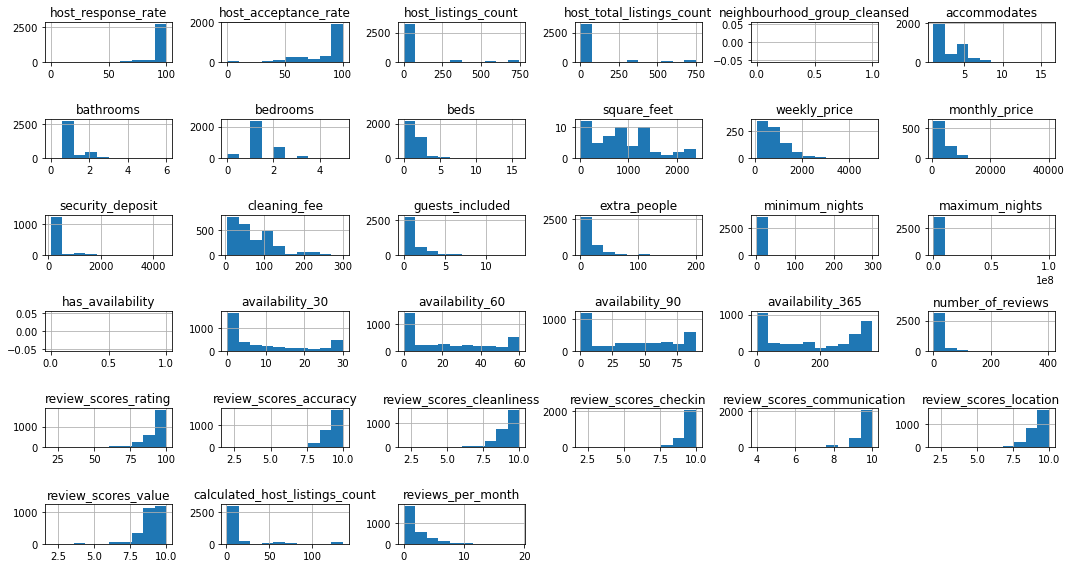

In [26]:
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True
listings.hist();

In [27]:
listings.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,accommodates,bathrooms,bedrooms,beds,square_feet,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3114.000000,3114.000000,3585.000000,3585.000000,0.0,3585.000000,3571.000000,3575.000000,3576.000000,56.000000,...,3585.000000,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,3585.000000,2829.000000
mean,94.989082,84.173089,58.902371,58.902371,NaN,3.041283,1.221647,1.255944,1.609060,858.464286,...,19.044630,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,12.733891,1.970908
std,12.517686,21.779254,171.119663,171.119663,NaN,1.778929,0.501487,0.753060,1.011745,608.874310,...,35.571658,9.531686,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,29.415076,2.120561
min,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000
25%,97.000000,71.000000,1.000000,1.000000,NaN,2.000000,1.000000,1.000000,1.000000,415.000000,...,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.480000
50%,100.000000,94.000000,2.000000,2.000000,NaN,2.000000,1.000000,1.000000,1.000000,825.000000,...,5.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.170000
75%,100.000000,100.000000,7.000000,7.000000,NaN,4.000000,1.000000,2.000000,2.000000,1200.000000,...,21.000000,98.250000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.720000
max,100.000000,100.000000,749.000000,749.000000,NaN,16.000000,6.000000,5.000000,16.000000,2400.000000,...,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000


In [28]:
listings.isna().sum().sort_values(ascending=False).head(20)

neighbourhood_group_cleansed    3585
has_availability                3585
square_feet                     3529
monthly_price                   2697
weekly_price                    2693
security_deposit                2243
notes                           1975
interaction                     1554
access                          1489
neighborhood_overview           1415
host_about                      1309
transit                         1290
house_rules                     1192
cleaning_fee                    1107
space                           1057
review_scores_accuracy           823
review_scores_location           822
review_scores_value              821
review_scores_checkin            820
review_scores_communication      818
dtype: int64

In [29]:
listings.shape[0]/2

1792.5

Analyze Columns with over 50% of data missing

- has_availability                3585
- license                         3585
- neighbourhood_group_cleansed    3585
- jurisdiction_names              3585
- square_feet                     3529
- monthly_price                   2697
- weekly_price                    2693
- security_deposit                2243
- notes                           1975

In [30]:
#dropping columns with data completly missing
listings.drop(columns=['has_availability', 'license', 'neighbourhood_group_cleansed', 'jurisdiction_names'], axis=1, inplace=True)

In [31]:
listings[['square_feet','monthly_price', 'weekly_price', 'security_deposit', 'notes']].isna().sum()/listings.shape[0]

square_feet         0.984379
monthly_price       0.752301
weekly_price        0.751185
security_deposit    0.625662
notes               0.550907
dtype: float64

In [32]:
listings.drop(['square_feet', 'monthly_price', 'weekly_price', 'security_deposit', 'notes'], axis=1, inplace=True)

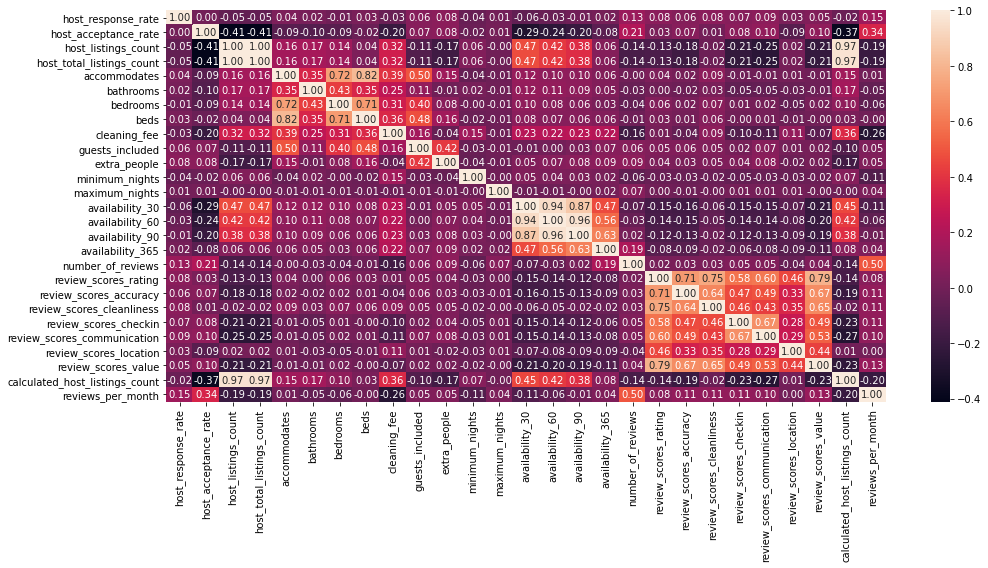

In [33]:
sns.heatmap(listings.corr(), annot=True, fmt=".2f");

In [34]:
listings.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3114.000000,3114.000000,3585.000000,3585.000000,3585.000000,3571.000000,3575.000000,3576.000000,2478.000000,3585.000000,...,3585.000000,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,3585.000000,2829.000000
mean,94.989082,84.173089,58.902371,58.902371,3.041283,1.221647,1.255944,1.609060,68.380145,1.429847,...,19.044630,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,12.733891,1.970908
std,12.517686,21.779254,171.119663,171.119663,1.778929,0.501487,0.753060,1.011745,51.297835,1.056787,...,35.571658,9.531686,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,29.415076,2.120561
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000
25%,97.000000,71.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,25.000000,1.000000,...,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.480000
50%,100.000000,94.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,50.000000,1.000000,...,5.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.170000
75%,100.000000,100.000000,7.000000,7.000000,4.000000,1.000000,2.000000,2.000000,100.000000,1.000000,...,21.000000,98.250000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.720000
max,100.000000,100.000000,749.000000,749.000000,16.000000,6.000000,5.000000,16.000000,300.000000,14.000000,...,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000


<AxesSubplot:>

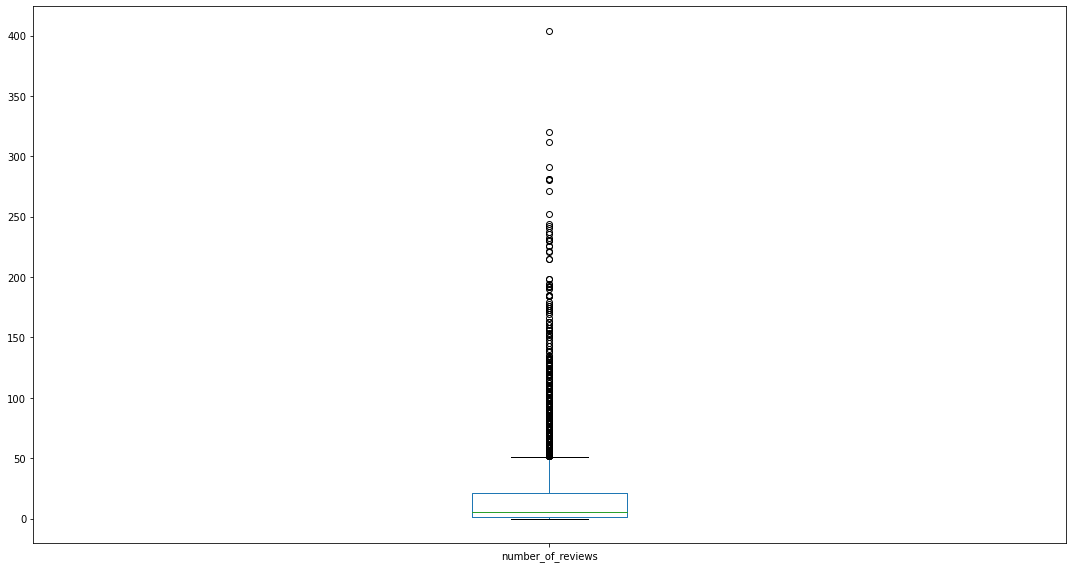

In [35]:
listings.number_of_reviews.plot(kind='box')

In [36]:
listings.nunique()

id                                  3585
listing_url                         3585
scrape_id                              1
last_scraped                           1
name                                3504
                                    ... 
cancellation_policy                    4
require_guest_profile_picture          2
require_guest_phone_verification       2
calculated_host_listings_count        25
reviews_per_month                    644
Length: 86, dtype: int64

### Cleaning
- converted id columns to strings
- converted price columns to floats
- dropped rows with 100% missing data
- 98% of sq feet missing best to drop because not enough mean or mode to help create accurate results
- both monthly price and weekly price are missing 75% of their data. 75% is significant enough to not be able to use mean or mode to fill. Not worth computing missing monthly price from weekly price and vice versa
- dropping security deposit because I don't think it will be useful with it missing 62% of the data
- dropping notes because I don't think it will be useful with it missing 55% of the data

### Findings
- review scores ratings is scored from 1-100 while the other review score columns are from 1-10


# Reviews

In [37]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [38]:
reviews.shape

(68275, 6)

In [39]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [40]:
reviews.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         53
dtype: int64

In [41]:
reviews.listing_id = reviews.listing_id.astype(str)
reviews.id = reviews.id.astype(str)
reviews.reviewer_id = reviews.reviewer_id.astype(str)

In [42]:
reviews[['listing_id', 'id']]

,listing_id,id
0,1178162,4724140
1,1178162,4869189
2,1178162,5003196
3,1178162,5150351
4,1178162,5171140
...,...,...
68270,7462268,80537457
68271,7462268,83640094
68272,7462268,85797088
68273,7462268,97264637


In [43]:
reviews.nunique()

listing_id        2829
id               68275
date              2045
reviewer_id      63789
reviewer_name    14775
comments         67311
dtype: int64

In [44]:
reviews.listing_id.value_counts()

66288       404
1497879     320
414419      312
31796       291
815639      281
           ... 
13512551      1
7325084       1
13699440      1
5959740       1
9530285       1
Name: listing_id, Length: 2829, dtype: int64

In [45]:
reviews[reviews.listing_id == '66288']

,listing_id,id,date,reviewer_id,reviewer_name,comments
53219,66288,170768,2011-01-15,278078,Kevin,Great location. Close to a drug store and groc...
53220,66288,174730,2011-01-25,343508,Sabrina,Definitely a good offer for short term staying...
53221,66288,190838,2011-03-01,388743,Rishiraj,"The location is great, there is a T-stop pract..."
53222,66288,197443,2011-03-12,420882,Michelle,"A perfect place to stay, especially if you are..."
53223,66288,206552,2011-03-22,419758,Sarah,"Sean was super cool, very helpful, and an amaz..."
...,...,...,...,...,...,...
53618,66288,88019624,2016-07-22,59312818,Christine,"Pros-\r\n\r\nWonderful neighbourhood, lively b..."
53619,66288,88245567,2016-07-23,63506669,Kira,Sean's appartement was perfect for our first n...
53620,66288,91066820,2016-08-03,45981734,Ugo,"The apartment is really well located, with the..."
53621,66288,94677297,2016-08-16,87479787,Kimberly,This place was pretty much what we expected an...


### Cleaning
- converted id columns to strings

### Findings
- review ids are unique

# Merge Datasets

- on listing ID?

In [46]:
listings.id.value_counts(), reviews.listing_id.value_counts(), calendar.listing_id.value_counts()

(8552338     1
 9218288     1
 994317      1
 13015832    1
 5004278     1
            ..
 1200502     1
 13028092    1
 3021862     1
 8029788     1
 4107959     1
 Name: id, Length: 3585, dtype: int64,
 66288       404
 1497879     320
 414419      312
 31796       291
 815639      281
            ... 
 13512551      1
 7325084       1
 13699440      1
 5959740       1
 9530285       1
 Name: listing_id, Length: 2829, dtype: int64,
 1529393     365
 6627802     365
 13490438    365
 2384581     365
 3371091     365
            ... 
 4410142       1
 13004551      1
 13992811      1
 13744821      1
 894539        1
 Name: listing_id, Length: 2906, dtype: int64)

In [47]:
listings[listings.id == '66288'].number_of_reviews

414    404
Name: number_of_reviews, dtype: int64

In [48]:
calendar[calendar.listing_id == '66288']

,listing_id,date,available,price
151110,66288,2017-09-05,t,75.0
151111,66288,2017-09-04,t,75.0
151112,66288,2017-09-03,t,75.0
151113,66288,2017-09-02,t,75.0
151114,66288,2017-09-01,t,75.0
...,...,...,...,...
151397,66288,2016-11-22,t,75.0
151402,66288,2016-11-17,t,75.0
151439,66288,2016-10-11,t,75.0
151446,66288,2016-10-04,t,75.0


Create new columns in listing using Calendars median price per id . Only count when available is true.

In [49]:
calendar[(calendar.listing_id == '66288') & (calendar.available == 't')].price.median()

75.0

In [50]:
id_list = []
for index, row in calendar.iterrows():
    if row.listing_id not in id_list:
        id_list.append(row.listing_id)

In [51]:
len(id_list), calendar.listing_id.nunique()

(2906, 2906)

In [52]:
calendar.price.isna().sum()

0

In [53]:
id_price = {}
for id in id_list:
        price = calendar[(calendar.listing_id == id) & (calendar.available == 't')].price.median()
        id_price[id] = price

In [54]:
id_price

{'3075044': 65.0,
 '6976': 65.0,
 '1436513': 75.0,
 '7651065': 79.0,
 '12386020': 75.0,
 '5706985': 100.0,
 '2843445': 75.0,
 '753446': 58.0,
 '849408': 229.0,
 '12023024': 60.0,
 '1668313': 57.0,
 '13547301': 150.0,
 '5434353': 145.0,
 '225979': 60.0,
 '3420384': 165.0,
 '7482195': 49.0,
 '7252607': 49.0,
 '2583074': 40.0,
 '13251243': 120.0,
 '225834': 70.0,
 '894539': 95.0,
 '879929': 90.0,
 '9218312': 95.0,
 '321328': 100.0,
 '1810172': 67.0,
 '6513924': 55.0,
 '7093109': 200.0,
 '14690527': 150.0,
 '7086825': 49.0,
 '1861070': 75.0,
 '4283698': 110.0,
 '10116095': 115.0,
 '8548176': 150.0,
 '4922204': 200.0,
 '4085362': 75.0,
 '3755609': 78.0,
 '1936861': 60.0,
 '4461111': 45.0,
 '1724900': 130.0,
 '13937181': 40.0,
 '3968797': 85.0,
 '1494726': 75.0,
 '8473851': 50.0,
 '3575220': 45.0,
 '1591827': 60.0,
 '3229255': 99.0,
 '1721016': 80.0,
 '12535687': 110.0,
 '12994227': 65.0,
 '12927298': 285.0,
 '169938': 140.0,
 '594693': 70.0,
 '2384581': 95.0,
 '4262255': 80.0,
 '4000384': 9

In [55]:
listings['price'] = listings['id'].map(id_price)

In [56]:
listings.price.isna().sum()

679

### Observation
- Merged price from calendar to listings by Id. 
- I used median to determine price per ID if ID has multiple transactions in calendar because it will provide price normally seen in airbnb price listings
- Nothing really useful from the reviews dataset to merge into listings

# Preprocessing Data

- Drop columns that are not useful for the evaluation
- evaluate rows with missing data

In [57]:
df = listings.copy()

In [58]:
df.shape

(3585, 86)

In [59]:
df.isna().sum().sort_values(ascending=False)

interaction              1554
access                   1489
neighborhood_overview    1415
host_about               1309
transit                  1290
                         ... 
country                     0
latitude                    0
longitude                   0
is_location_exact           0
smart_location              0
Length: 86, dtype: int64

In [60]:
df.duplicated().sum()

0

In [61]:
df.shape[1]/2

43.0

In [62]:
missing_rows = df[df.isna().any(axis=1)]

In [63]:
missing_rows.isna().sum(axis=1).sort_values(ascending=False)

3300    26
1836    26
1923    26
3223    25
2266    24
        ..
814      1
3169     1
562      1
816      1
2480     1
Length: 3094, dtype: int64

Most a row is missing is 26 columns or data.

# Target Variable

- price

In [64]:
df.price.isna().sum(), df.price.isna().sum()/df.shape[0]

(679, 0.1894002789400279)

In [65]:
df.dropna(subset=['price'], inplace=True)

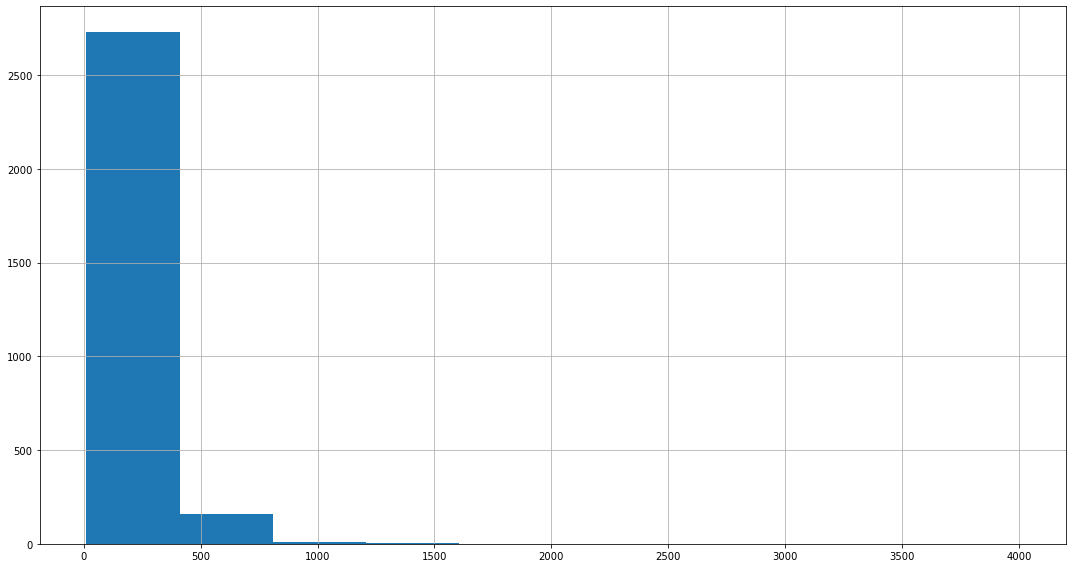

In [66]:
df.price.hist();

In [67]:
df.price.describe(), df.price.median(), df.price.mode()

(count    2906.000000
 mean      192.213868
 std       156.151633
 min        11.000000
 25%        89.000000
 50%       158.000000
 75%       250.000000
 max      4000.000000
 Name: price, dtype: float64,
 158.0,
 0    150.0
 dtype: float64)

<AxesSubplot:>

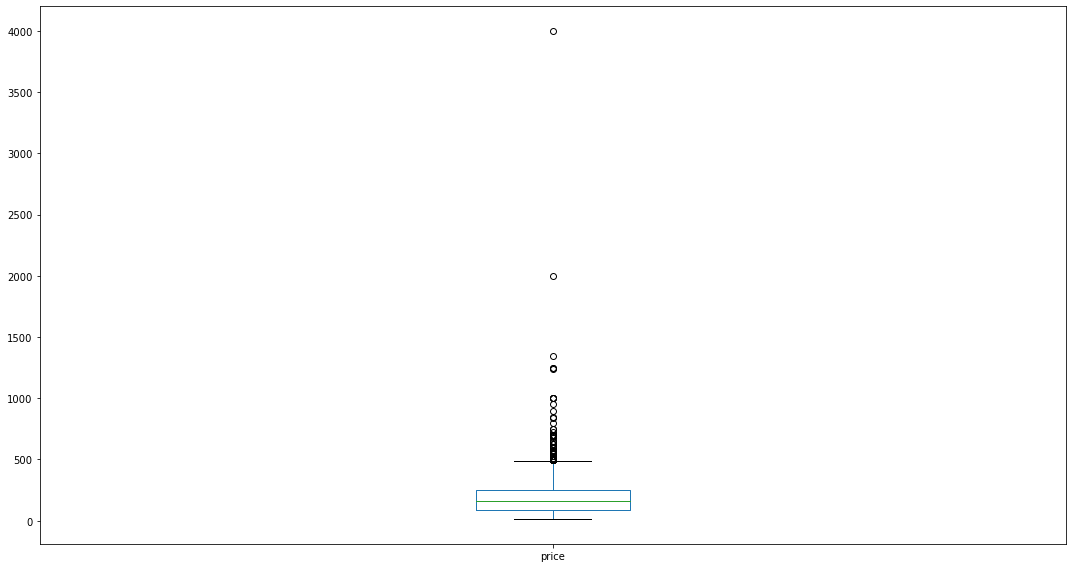

In [68]:
df.price.plot(kind='box')

### Target Variable Cleaning/Observations

- dropped rows missing a price 
- Average price 192.21
- Median price is now 158
- Mode price is still 150
- Outlier is now 4000

# Numerical Values
- Drop columns that do not fit the analysis.
- Preprocess data for linear regression model

In [69]:
num_cols = df.select_dtypes(include=['float', 'int']).columns

In [70]:
df[num_cols].isna().sum()

host_response_rate                125
host_acceptance_rate              125
host_listings_count                 0
host_total_listings_count           0
accommodates                        0
bathrooms                          14
bedrooms                           10
beds                                8
price                               0
cleaning_fee                      795
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
review_scores_rating              554
review_scores_accuracy            562
review_scores_cleanliness         559
review_scores_checkin             559
review_scores_communication       559
review_scores_location            561
review_scores_value               560
calculated_h

In [71]:
df[num_cols].nunique()

host_response_rate                 50
host_acceptance_rate               71
host_listings_count                35
host_total_listings_count          35
accommodates                       14
bathrooms                          12
bedrooms                            6
beds                               10
price                             397
cleaning_fee                       77
guests_included                    13
extra_people                       50
minimum_nights                     25
maximum_nights                     79
availability_30                    31
availability_60                    61
availability_90                    91
availability_365                  347
number_of_reviews                 178
review_scores_rating               46
review_scores_accuracy              8
review_scores_cleanliness           9
review_scores_checkin               8
review_scores_communication         7
review_scores_location              9
review_scores_value                 9
calculated_h

In [72]:
df[num_cols].maximum_nights.value_counts()

1125    2022
365      132
30        85
90        55
7         50
        ... 
84         1
146        1
96         1
130        1
42         1
Name: maximum_nights, Length: 79, dtype: int64

In [73]:
#dropping columns that are not location, size, or reviews
df.drop(columns=['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 
                 'cleaning_fee', 'minimum_nights', 'maximum_nights','availability_30', 'availability_60', 
                 'availability_90', 'availability_365', 'calculated_host_listings_count'], axis=1, inplace=True)

In [74]:
num_cols = df.select_dtypes(include=['float', 'int']).columns
df_nums = df[num_cols]

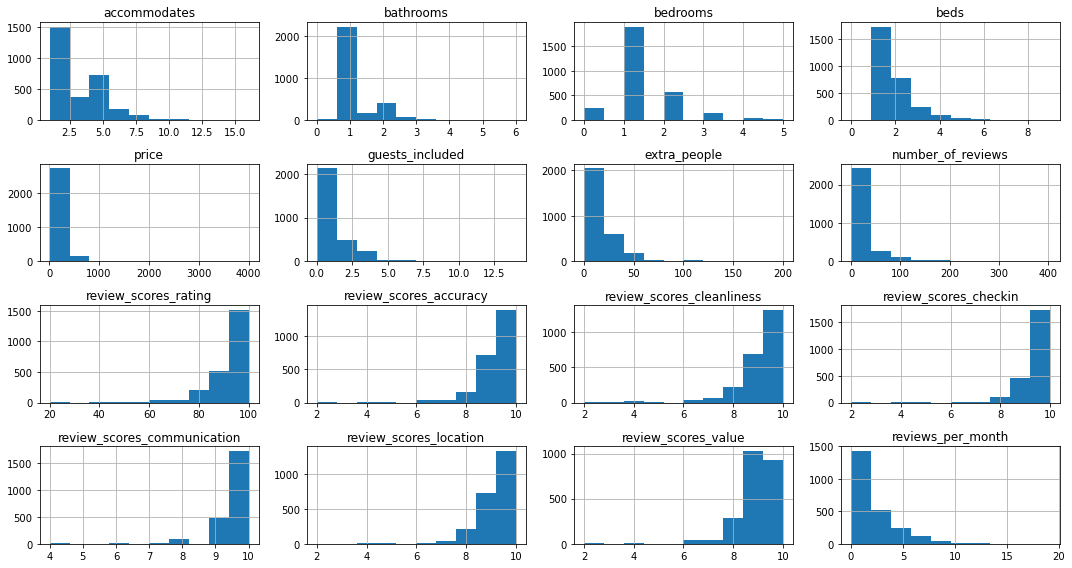

In [75]:
df[num_cols].hist();

In [76]:
df_nums[df_nums.bedrooms.isnull()]

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
918,2,1.0,NaN,1.0,176.0,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,2,1.0,NaN,1.0,229.0,1,0.0,9,89.0,10.0,10.0,10.0,9.0,10.0,8.0,0.15
924,2,1.0,NaN,1.0,275.0,1,0.0,1,NaN,10.0,10.0,10.0,8.0,10.0,6.0,0.03
1095,2,1.0,NaN,1.0,186.0,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1117,2,1.0,NaN,1.0,269.0,1,0.0,1,91.0,8.0,10.0,10.0,10.0,10.0,8.0,0.03
1132,2,1.0,NaN,1.0,225.0,2,0.0,4,90.0,10.0,9.0,10.0,10.0,9.0,9.0,0.05
1251,2,1.0,NaN,1.0,209.0,1,0.0,22,78.0,8.0,9.0,10.0,9.0,10.0,8.0,0.35
1366,2,1.0,NaN,1.0,209.0,1,0.0,6,87.0,9.0,10.0,9.0,9.0,10.0,9.0,0.17
1419,2,1.0,NaN,1.0,209.0,1,0.0,17,92.0,8.0,9.0,10.0,10.0,10.0,9.0,0.42
1959,2,1.0,NaN,1.0,175.0,2,0.0,127,92.0,9.0,9.0,10.0,10.0,10.0,9.0,1.67


In [77]:
df_nums[df_nums.bathrooms.isnull()]

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
103,2,NaN,1.0,1.0,85.0,1,0.0,17,94.0,10.0,9.0,10.0,10.0,10.0,10.0,0.43
630,1,NaN,1.0,1.0,35.0,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,2,NaN,1.0,NaN,159.0,1,0.0,73,91.0,10.0,9.0,9.0,9.0,10.0,9.0,1.97
800,4,NaN,1.0,1.0,203.0,1,0.0,54,82.0,9.0,9.0,9.0,8.0,9.0,8.0,1.02
820,2,NaN,1.0,NaN,60.0,1,20.0,10,58.0,6.0,5.0,8.0,8.0,5.0,6.0,5.45
825,2,NaN,1.0,NaN,60.0,1,20.0,14,62.0,7.0,5.0,8.0,8.0,5.0,6.0,4.62
888,4,NaN,1.0,1.0,199.0,1,0.0,65,86.0,9.0,9.0,9.0,8.0,9.0,8.0,1.35
910,1,NaN,1.0,NaN,53.0,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989,1,NaN,1.0,1.0,98.0,1,0.0,184,91.0,9.0,8.0,10.0,9.0,10.0,9.0,3.09
1120,1,NaN,1.0,1.0,135.0,1,12.0,215,88.0,9.0,8.0,9.0,9.0,10.0,9.0,3.46


In [78]:
df_nums[df_nums.beds.isnull()]

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
494,1,1.0,1.0,NaN,95.0,1,50.0,1,100.0,10.0,10.0,10.0,10.0,10.0,8.0,1.00
755,2,NaN,1.0,NaN,159.0,1,0.0,73,91.0,10.0,9.0,9.0,9.0,10.0,9.0,1.97
820,2,NaN,1.0,NaN,60.0,1,20.0,10,58.0,6.0,5.0,8.0,8.0,5.0,6.0,5.45
825,2,NaN,1.0,NaN,60.0,1,20.0,14,62.0,7.0,5.0,8.0,8.0,5.0,6.0,4.62
910,1,NaN,1.0,NaN,53.0,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2819,2,NaN,1.0,NaN,57.0,1,12.0,12,87.0,9.0,9.0,8.0,9.0,9.0,9.0,1.20
2865,2,1.0,1.0,NaN,60.0,1,20.0,3,93.0,9.0,9.0,10.0,10.0,9.0,9.0,0.88
3557,2,1.0,1.0,NaN,60.0,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
df.bedrooms.value_counts(), df.bathrooms.value_counts(), df.beds.value_counts()

(1.0    1894
 2.0     566
 0.0     249
 3.0     133
 4.0      40
 5.0      14
 Name: bedrooms, dtype: int64,
 1.0    2216
 2.0     399
 1.5     164
 2.5      60
 3.0      15
 0.0      11
 3.5      11
 5.0       5
 6.0       4
 0.5       4
 4.0       2
 4.5       1
 Name: bathrooms, dtype: int64,
 1.0    1720
 2.0     783
 3.0     232
 4.0      95
 5.0      35
 6.0      16
 8.0       6
 7.0       6
 0.0       3
 9.0       2
 Name: beds, dtype: int64)

In [80]:
bedroom = df.bedrooms.median()
df.bedrooms.fillna(bedroom, inplace=True)

In [81]:
df.dropna(subset=['bathrooms'], inplace=True)
df.dropna(subset=['beds'], inplace=True)

In [82]:
df[df.bedrooms.isnull()]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month


In [83]:
df_nums = df[num_cols]

In [84]:
df_nums.isna().sum()

accommodates                     0
bathrooms                        0
bedrooms                         0
beds                             0
price                            0
guests_included                  0
extra_people                     0
number_of_reviews                0
review_scores_rating           551
review_scores_accuracy         559
review_scores_cleanliness      556
review_scores_checkin          556
review_scores_communication    556
review_scores_location         558
review_scores_value            557
reviews_per_month              515
dtype: int64

In [85]:
#df.cleaning_fee.describe(), df.cleaning_fee.median()

In [86]:
#df.cleaning_fee.hist()

In [87]:
# cleaning = df.cleaning_fee.mean()
# df.cleaning_fee = df.cleaning_fee.fillna(cleaning)
# df_nums = df[num_cols]

In [88]:
df_nums.isna().sum()

accommodates                     0
bathrooms                        0
bedrooms                         0
beds                             0
price                            0
guests_included                  0
extra_people                     0
number_of_reviews                0
review_scores_rating           551
review_scores_accuracy         559
review_scores_cleanliness      556
review_scores_checkin          556
review_scores_communication    556
review_scores_location         558
review_scores_value            557
reviews_per_month              515
dtype: int64

In [89]:
df_nums[df_nums.review_scores_accuracy.isnull()].isnull().sum()

accommodates                     0
bathrooms                        0
bedrooms                         0
beds                             0
price                            0
guests_included                  0
extra_people                     0
number_of_reviews                0
review_scores_rating           550
review_scores_accuracy         559
review_scores_cleanliness      556
review_scores_checkin          556
review_scores_communication    556
review_scores_location         555
review_scores_value            555
reviews_per_month              515
dtype: int64

When review scores accuracy is missing, the other reviews scores are most likely missing as well. Drop those rows

In [90]:
df.dropna(subset=['review_scores_accuracy', 'review_scores_rating', 'review_scores_location', 'review_scores_value'], inplace=True)

In [91]:
df_nums = df[num_cols]
df_nums.shape, df.shape

((2325, 16), (2325, 74))

In [92]:
df_nums.isna().sum()

accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
price                          0
guests_included                0
extra_people                   0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64

In [93]:
df_nums.isna().sum()

accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
price                          0
guests_included                0
extra_people                   0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64

In [94]:
df.review_scores_rating = df.review_scores_rating/10

In [95]:
df.describe()

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,3.130323,1.223871,1.262366,1.649892,184.708172,1.515699,12.647742,27.843871,9.193677,9.431398,9.304516,9.643871,9.650323,9.400430,9.150108,2.176344
std,1.870543,0.514307,0.790422,1.052211,132.618397,1.147600,19.302048,40.822347,0.895686,0.896135,1.086690,0.751683,0.721776,0.894668,0.980141,2.193995
min,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,0.020000
25%,2.000000,1.000000,1.000000,1.000000,88.000000,1.000000,0.000000,4.000000,8.900000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.610000
50%,2.000000,1.000000,1.000000,1.000000,150.000000,1.000000,0.000000,13.000000,9.400000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.450000
75%,4.000000,1.000000,2.000000,2.000000,245.000000,2.000000,20.000000,33.000000,9.800000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000
max,16.000000,6.000000,5.000000,9.000000,2000.000000,14.000000,200.000000,404.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,19.150000


### Numerical
- filled missing bedroom values with median because bedrooms has to be a whole number.
- dropped missing beds and bathrooms because no way to determine how many beds and bathrooms are in a rental
- Divided review scores rating by 10 to align with other review score columns
- Thinking about converting bedrooms, bathrooms, and beds to categorical

# Categorical Values
- drop columns that do not fit the analysis
- preprocess rows for linear regression model
    - create dummy variables and columns (0,1)

In [96]:
cat_cols = df.select_dtypes(include=['object']).columns

In [97]:
df_cat = df[cat_cols]
df_cat

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,amenities,calendar_updated,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",a week ago,2016-09-06,2014-06-01,2016-08-13,f,t,moderate,f,f
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",5 days ago,2016-09-06,2009-07-19,2016-08-05,f,f,moderate,t,f
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",a week ago,2016-09-06,2016-08-28,2016-08-28,f,f,moderate,f,f
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,"{Internet,""Wireless Internet"",""Air Conditionin...",2 weeks ago,2016-09-06,2015-08-18,2016-09-01,f,f,flexible,f,f
5,12386020,https://www.airbnb.com/rooms/12386020,20160906204935,2016-09-07,Private Bedroom + Great Coffee,Super comfy bedroom plus your own bathroom in ...,Our sunny condo is located on the second and t...,Super comfy bedroom plus your own bathroom in ...,none,We love our corner of Roslindale! For quiet wa...,...,"{""Cable TV"",""Wireless Internet"",""Air Condition...",2 weeks ago,2016-09-06,2016-04-20,2016-08-28,f,f,flexible,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,14743129,https://www.airbnb.com/rooms/14743129,20160906204935,2016-09-07,Hancock Village rent out one room,"我的房源走路2 minutes有shopping mall,包括CVS,restuarant...",NaN,"我的房源走路2 minutes有shopping mall,包括CVS,restuarant...",none,"走路2 minutes有shopping mall,包括CVS,restuarant,ban...",...,"{""Wireless Internet"",Kitchen,""Free Parking on ...",yesterday,2016-09-06,2016-09-01,2016-09-01,f,f,moderate,f,f
3575,5280827,https://www.airbnb.com/rooms/5280827,20160906204935,2016-09-07,Private cozy room,"Cozy room near T station. 5 min walking to T, ...",NaN,"Cozy room near T station. 5 min walking to T, ...",none,NaN,...,"{Internet,""Wireless Internet"",""Air Conditionin...",a week ago,2016-09-06,2015-03-07,2016-08-20,f,t,strict,f,f
3578,14536322,https://www.airbnb.com/rooms/14536322,20160906204935,2016-09-07,Victorian Garden Level Room - Omega,Exquisite garden level (semi basement) room in...,"Very safe, bustling with shops, restaurants, H...",Exquisite garden level (semi basement) room in...,none,"Safe, in the midst of all Harvard Square actio...",...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",3 weeks ago,2016-09-06,2016-09-06,2016-09-06,f,t,strict,f,f
3580,8373729,https://www.airbnb.com/rooms/8373729,20160906204935,2016-09-07,Big cozy room near T,5 min walking to Orange Line subway with 2 sto...,NaN,5 min walking to Orange Line subway with 2 sto...,none,NaN,...,"{Internet,""Wireless Internet"",""Air Conditionin..

In [98]:
for col in df_cat.columns:
    print(col + ' ' + str(df_cat[col].nunique()))
    

id 2325
listing_url 2325
scrape_id 1
last_scraped 1
name 2282
summary 2017
space 1676
description 2232
experiences_offered 1
neighborhood_overview 1302
transit 1384
access 1334
interaction 1222
house_rules 1453
thumbnail_url 1901
medium_url 1901
picture_url 2325
xl_picture_url 1901
host_id 1363
host_url 1363
host_name 901
host_since 970
host_location 111
host_about 903
host_response_time 4
host_is_superhost 2
host_thumbnail_url 1360
host_picture_url 1360
host_neighbourhood 46
host_verifications 49
host_has_profile_pic 2
host_identity_verified 2
street 965
neighbourhood 29
neighbourhood_cleansed 25
city 31
state 1
zipcode 40
market 2
smart_location 32
country_code 1
country 1
latitude 2325
longitude 2325
is_location_exact 2
property_type 12
room_type 3
bed_type 5
amenities 2030
calendar_updated 31
calendar_last_scraped 1
first_review 925
last_review 314
requires_license 1
instant_bookable 2
cancellation_policy 4
require_guest_profile_picture 2
require_guest_phone_verification 2


In [99]:
df_cat.scrape_id.value_counts()

20160906204935    2325
Name: scrape_id, dtype: int64

In [100]:
#dropping columns that are not location, size, or reviews
df.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'space', 'summary',
                'description', 'experiences_offered', 'neighborhood_overview', 'transit', 'access', 'interaction',
                'house_rules', 'thumbnail_url', 'medium_url', 'thumbnail_url', 'picture_url', 'xl_picture_url',
                'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_is_superhost', 
                'host_thumbnail_url', 'host_picture_url', 'host_response_time', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy', 
                'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 'instant_bookable',
                 'require_guest_profile_picture', 'require_guest_phone_verification'], axis=1, inplace=True)

In [101]:
cat_cols = df.select_dtypes(include=['object']).columns
df_cat = df[cat_cols]

In [102]:
df_cat.isna().sum().sort_values(ascending=False)

neighbourhood             355
host_neighbourhood        203
zipcode                    18
market                      5
city                        2
property_type               2
host_id                     0
latitude                    0
bed_type                    0
room_type                   0
is_location_exact           0
longitude                   0
smart_location              0
country                     0
country_code                0
state                       0
neighbourhood_cleansed      0
street                      0
amenities                   0
dtype: int64

In [103]:
df_cat.neighbourhood.value_counts()

Jamaica Plain         221
South End             209
Back Bay              192
Allston-Brighton      191
South Boston          154
Dorchester            149
Beacon Hill           126
Fenway/Kenmore        126
East Boston            99
Roxbury                87
North End              83
Charlestown            54
Mission Hill           43
Roslindale             42
Chinatown              42
West End               32
West Roxbury           26
Downtown Crossing      20
Theater District       20
Hyde Park              15
Mattapan               12
Somerville              7
Downtown                7
Government Center       3
Leather District        3
Financial District      2
Cambridge               2
Chestnut Hill           2
Brookline               1
Name: neighbourhood, dtype: int64

In [104]:
df_cat.host_neighbourhood.value_counts()

Jamaica Plain                222
Allston-Brighton             211
Back Bay                     210
Dorchester                   162
South End                    160
South Boston                 147
Beacon Hill                  135
Fenway/Kenmore               131
Roxbury                      114
East Boston                   97
North End                     82
West End                      51
Mission Hill                  45
Roslindale                    45
Cambridge                     44
Charlestown                   43
Gay Village                   33
Downtown Crossing             28
West Roxbury                  24
Hyde Park                     21
Mattapan                      16
Theater District              15
Somerville                    12
Central Business District     11
Downtown                      11
Medford                       10
Chinatown                      9
South Beach                    4
Financial District             4
Upper East Side                3
Flatiron D

In [105]:
df_cat.zipcode.value_counts()

02116          259
02130          230
02118          176
02114          145
02127          136
02128          125
02134          122
02215          120
02135           99
02125           95
02115           88
02119           81
02113           63
02124           62
02108           59
02129           59
02111           55
02131           54
02120           53
02210           48
02122           34
02132           26
02109           26
02121           21
02136           20
02126           18
02110           11
02145            5
02143            3
02141            2
02467            2
02445            2
02446            1
02138            1
02142            1
02139            1
02108 02111      1
02134-1704       1
02163            1
02186            1
Name: zipcode, dtype: int64

In [106]:
df_cat.host_neighbourhood.value_counts()

Jamaica Plain                222
Allston-Brighton             211
Back Bay                     210
Dorchester                   162
South End                    160
South Boston                 147
Beacon Hill                  135
Fenway/Kenmore               131
Roxbury                      114
East Boston                   97
North End                     82
West End                      51
Mission Hill                  45
Roslindale                    45
Cambridge                     44
Charlestown                   43
Gay Village                   33
Downtown Crossing             28
West Roxbury                  24
Hyde Park                     21
Mattapan                      16
Theater District              15
Somerville                    12
Central Business District     11
Downtown                      11
Medford                       10
Chinatown                      9
South Beach                    4
Financial District             4
Upper East Side                3
Flatiron D

In [107]:
df_cat.property_type.value_counts()

Apartment          1624
House               430
Condominium         152
Townhouse            41
Loft                 26
Bed & Breakfast      26
Boat                 11
Other                 9
Guesthouse            1
Villa                 1
Entire Floor          1
Dorm                  1
Name: property_type, dtype: int64

In [108]:
df_cat.city.value_counts()

Boston                    2197
Jamaica Plain               17
Dorchester                  12
Charlestown                 12
Brighton                    12
Roxbury Crossing            12
Somerville                   8
Allston                      7
Roslindale                   6
Cambridge                    5
Brookline                    5
West Roxbury                 4
East Boston                  3
Jamaica Plain, Boston        2
Mattapan                     2
Jamaica Plain                2
ROXBURY CROSSING             2
South Boston                 2
Milton                       1
ALLSTON                      1
east Boston                  1
South End, Boston            1
Jamaica Plain, MA            1
Roslindale, Boston           1
Jamaica Plain (Boston)       1
Boston (Jamaica Plain)       1
Mission Hill, Boston         1
Hyde Park                    1
Boston                       1
dorchester, boston           1
Brighton                     1
Name: city, dtype: int64

In [109]:
neighbor = df_cat[['neighbourhood', 'zipcode', 'city']]
neighbor

,neighbourhood,zipcode,city
1,Roslindale,02131,Boston
2,Roslindale,02131,Boston
3,NaN,NaN,Boston
4,Roslindale,02131,Boston
5,Roslindale,02131,Boston
...,...,...,...
3574,Chestnut Hill,02467,NaN
3575,Somerville,02143,Somerville
3578,NaN,02138,Cambridge
3580,Somerville,02143,Somerville


In [110]:
neighbor[neighbor.zipcode.isna()]

,neighbourhood,zipcode,city
3,NaN,NaN,Boston
94,NaN,NaN,Brookline
162,NaN,NaN,Boston
226,NaN,NaN,Boston
675,North End,NaN,Boston
882,NaN,NaN,Boston
1150,NaN,NaN,Boston
1212,South End,NaN,Boston
1385,NaN,NaN,Boston
2151,NaN,NaN,Boston


In [111]:
neighbor[neighbor.neighbourhood == 'Fenway/Kenmore'].zipcode.value_counts()

02215    101
02115     24
Name: zipcode, dtype: int64

In [112]:
missing_zips = ['North End', 'South End', 'Fenway/Kenmore']
for neighborhood in missing_zips:
    mask = (neighbor.neighbourhood == neighborhood)
    hood = neighbor.loc[mask, 'zipcode'].value_counts().index[0]
    df.loc[mask, 'zipcode'] = df.loc[mask, 'zipcode'].fillna(hood)

In [113]:
df.dropna(subset=['zipcode'], inplace=True)

In [114]:
df_cat = df[cat_cols]
neighbor = df_cat[['neighbourhood', 'zipcode', 'city']]
df[df.zipcode.isna()].shape

(0, 35)

In [115]:
neighbor[neighbor.neighbourhood.isna()]

,neighbourhood,zipcode,city
6,NaN,02131,Boston
19,NaN,02131,Boston
64,NaN,02130,Boston
88,NaN,02130,Boston
150,NaN,02130,Boston
...,...,...,...
3531,NaN,02134,Boston
3554,NaN,02446,Brookline
3559,NaN,02129,Boston
3568,NaN,02143,Somerville


In [116]:
neighbor.isna().sum()

neighbourhood    340
zipcode            0
city               2
dtype: int64

In [117]:
zips = []
for index, row in neighbor.iterrows():
    if row.zipcode not in zips:
        zips.append(row.zipcode)

In [118]:
for zip in zips:
    print(zip)
    print(neighbor[neighbor.zipcode == zip].neighbourhood.value_counts())

02131
Roslindale       42
Jamaica Plain     6
West Roxbury      2
Hyde Park         1
Name: neighbourhood, dtype: int64
02130
Jamaica Plain    204
Mission Hill       4
Name: neighbourhood, dtype: int64
02119
Roxbury          55
Jamaica Plain    11
South End         1
Mission Hill      1
Name: neighbourhood, dtype: int64
02120
Mission Hill    37
Roxbury          9
Name: neighbourhood, dtype: int64
02115
Back Bay            47
Fenway/Kenmore      24
Mission Hill         1
Allston-Brighton     1
Name: neighbourhood, dtype: int64
02215
Fenway/Kenmore      102
Back Bay              4
Allston-Brighton      2
Name: neighbourhood, dtype: int64
02116
Back Bay            140
South End            62
Theater District     16
Chinatown            10
Name: neighbourhood, dtype: int64
02111
Chinatown            32
Downtown Crossing     6
Theater District      4
Leather District      3
Downtown              1
Name: neighbourhood, dtype: int64
02110
North End            6
Downtown Crossing    4
Name: ne

In [119]:
neighbor.neighbourhood.value_counts()

Jamaica Plain         221
South End             209
Back Bay              192
Allston-Brighton      191
South Boston          154
Dorchester            149
Beacon Hill           126
Fenway/Kenmore        126
East Boston            99
Roxbury                87
North End              83
Charlestown            54
Mission Hill           43
Roslindale             42
Chinatown              42
West End               32
West Roxbury           26
Downtown Crossing      20
Theater District       20
Hyde Park              15
Mattapan               12
Somerville              7
Downtown                7
Government Center       3
Leather District        3
Financial District      2
Cambridge               2
Chestnut Hill           2
Brookline               1
Name: neighbourhood, dtype: int64

In [120]:
drop_zips = []
for zip in zips:
    mask = (neighbor.zipcode == zip)
    try:
        hood = neighbor.loc[mask, 'neighbourhood'].value_counts().index[0]
        
    except IndexError: 
        drop_zips.append(zip)
   

In [121]:
df = df[df.zipcode.isin(drop_zips) == False]

In [122]:
df_cat = df[cat_cols]
neighbor = df_cat[['neighbourhood', 'zipcode', 'city']]
df[df.neighbourhood.isna()].shape

(336, 35)

In [123]:
zips = []
for index, row in neighbor.iterrows():
    if row.zipcode not in zips:
        zips.append(row.zipcode)

In [124]:
for zip in zips:
    mask = (neighbor.zipcode == zip)
    hood = neighbor.loc[mask, 'neighbourhood'].value_counts().index[0]
    df.loc[mask, 'neighbourhood'] = df.loc[mask, 'neighbourhood'].fillna(hood)

In [125]:
df_cat = df[cat_cols]
neighbor = df_cat[['neighbourhood', 'zipcode', 'city']]
df[df.neighbourhood.isna()]

,host_id,host_neighbourhood,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,...,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month


In [126]:
neighbor.neighbourhood.isna().sum(), neighbor.neighbourhood.value_counts() 

(0,
 Jamaica Plain         243
 Back Bay              238
 South End             230
 Allston-Brighton      227
 Dorchester            204
 South Boston          184
 Beacon Hill           153
 Fenway/Kenmore        139
 East Boston           124
 Roxbury               100
 North End              95
 Charlestown            60
 Chinatown              51
 Mission Hill           50
 Roslindale             45
 West End               32
 West Roxbury           29
 Hyde Park              22
 Downtown Crossing      20
 Theater District       20
 Mattapan               12
 Somerville              8
 Downtown                7
 Government Center       3
 Leather District        3
 Financial District      2
 Cambridge               2
 Chestnut Hill           2
 Brookline               1
 Name: neighbourhood, dtype: int64)

In [127]:
df_cat.isna().sum().sort_values(ascending=False)

host_neighbourhood        188
market                      5
property_type               2
city                        2
host_id                     0
country                     0
bed_type                    0
room_type                   0
is_location_exact           0
longitude                   0
latitude                    0
smart_location              0
country_code                0
zipcode                     0
state                       0
neighbourhood_cleansed      0
neighbourhood               0
street                      0
amenities                   0
dtype: int64

In [128]:
host = df_cat[['host_id', 'host_neighbourhood']]
host

,host_id,host_neighbourhood
1,2572247,Roslindale
2,16701,Roslindale
4,15396970,Roslindale
5,64200298,Roslindale
6,6570877,Roslindale
...,...,...
3573,42070843,Somerville
3574,91855319,Chestnut Hill
3575,19246369,Somerville
3580,19246369,Somerville


In [129]:
host.host_id.value_counts()

25188       60
30283594    51
9419684     45
22348222    35
12243051    33
            ..
431385       1
84922021     1
16701        1
7614614      1
11051232     1
Name: host_id, Length: 1347, dtype: int64

In [130]:
host[host.host_neighbourhood.isna()]

,host_id,host_neighbourhood
64,32449720,NaN
216,29531596,NaN
222,27112758,NaN
231,13897255,NaN
244,48876489,NaN
...,...,...
3468,18194953,NaN
3474,69252188,NaN
3515,49546656,NaN
3518,13565868,NaN


In [131]:
hosts = []
for index, row in host.iterrows():
    if row.host_id not in hosts:
        hosts.append(row.host_id)

In [132]:
host_list = []
for hos in hosts:
    mask = (host.host_id == hos)
    try:
        host_loc = host.loc[mask, 'host_neighbourhood'].value_counts().index[0]
    except:
        host_list.append(hos)
    #df.loc[mask, 'host_neighbourhood'] = df.loc[mask, 'host_neighbourhood'].fillna(host_loc)
    
print(len(host_list))

164


In [133]:
df.drop(['host_neighbourhood'], axis=1, inplace=True)

In [134]:
cat_cols = df.select_dtypes(include=['object']).columns
df_cat = df[cat_cols]
df_cat.isna().sum().sort_values(ascending=False)

market                    5
city                      2
property_type             2
host_id                   0
country                   0
bed_type                  0
room_type                 0
is_location_exact         0
longitude                 0
latitude                  0
country_code              0
street                    0
smart_location            0
zipcode                   0
state                     0
neighbourhood_cleansed    0
neighbourhood             0
amenities                 0
dtype: int64

In [135]:
df.drop(['host_id'], axis=1, inplace=True)

In [136]:
df.dropna(subset=['market'], inplace=True)
df.dropna(subset=['city'], inplace=True)
df.dropna(subset=['property_type'], inplace=True)


### Categorical
- used column values in neighbourhood to fill missing values in zipcode. 
- drop N/A rows in zipcode then used zipcode to find missing values in neighbourhood.
- dropped N/A in rows in columns market, city, and property type
- dropped host id and host neighbourhood after further analysis.

In [137]:
df.isna().sum().sort_values(ascending=False)

street                         0
bedrooms                       0
review_scores_value            0
review_scores_location         0
review_scores_communication    0
review_scores_checkin          0
review_scores_cleanliness      0
review_scores_accuracy         0
review_scores_rating           0
number_of_reviews              0
extra_people                   0
guests_included                0
price                          0
amenities                      0
bed_type                       0
beds                           0
bathrooms                      0
neighbourhood                  0
accommodates                   0
room_type                      0
property_type                  0
is_location_exact              0
longitude                      0
latitude                       0
country                        0
country_code                   0
smart_location                 0
market                         0
zipcode                        0
state                          0
city      

In [138]:
df.shape

(2297, 33)

# Dummy Variable 

In [139]:
df.shape, df.shape[0]/2, df.shape[1]/2

((2297, 33), 1148.5, 16.5)

In [140]:
df.bedrooms.value_counts(), df.bathrooms.value_counts(), df.beds.value_counts()

(1.0    1507
 2.0     425
 0.0     202
 3.0     116
 4.0      35
 5.0      12
 Name: bedrooms, dtype: int64,
 1.0    1772
 2.0     288
 1.5     143
 2.5      50
 3.0      14
 3.5      10
 0.0       8
 6.0       4
 0.5       3
 5.0       2
 4.0       2
 4.5       1
 Name: bathrooms, dtype: int64,
 1.0    1369
 2.0     594
 3.0     192
 4.0      82
 5.0      30
 6.0      14
 8.0       6
 7.0       5
 0.0       3
 9.0       2
 Name: beds, dtype: int64)

In [141]:
df.bedrooms =  df.bedrooms.astype(str)
df.beds =  df.beds.astype(str)
df.bathrooms =  df.bathrooms.astype(str)

In [142]:
df_cat = df.select_dtypes(include=['object']).columns

In [143]:
df_cat = df[df_cat]
df_cat.nunique()

street                     958
neighbourhood               28
neighbourhood_cleansed      25
city                        30
state                        1
zipcode                     35
market                       2
smart_location              30
country_code                 1
country                      1
latitude                  2297
longitude                 2297
is_location_exact            2
property_type               12
room_type                    3
bathrooms                   12
bedrooms                     6
beds                        10
bed_type                     5
amenities                 2002
dtype: int64

In [144]:
df.drop(['latitude', 'longitude', 'street', 'amenities', 'state', 'country', 'country_code', 'smart_location', 'city'], axis=1, inplace=True)

In [145]:
df = pd.get_dummies(df, columns=['zipcode', 'neighbourhood', 
                                'neighbourhood_cleansed', 'property_type', 'bed_type',   
                                'room_type', 'is_location_exact','market', 'bedrooms', 'beds', 'bathrooms'], dummy_na=True)

In [146]:
df.shape

(2297, 164)

In [147]:
for col in df.columns:
    print(col)

accommodates
price
guests_included
extra_people
number_of_reviews
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
reviews_per_month
zipcode_02108
zipcode_02108 02111
zipcode_02109
zipcode_02110
zipcode_02111
zipcode_02113
zipcode_02114
zipcode_02115
zipcode_02116
zipcode_02118
zipcode_02119
zipcode_02120
zipcode_02121
zipcode_02122
zipcode_02124
zipcode_02125
zipcode_02126
zipcode_02127
zipcode_02128
zipcode_02129
zipcode_02130
zipcode_02131
zipcode_02132
zipcode_02134
zipcode_02134-1704
zipcode_02135
zipcode_02136
zipcode_02139
zipcode_02141
zipcode_02143
zipcode_02145
zipcode_02163
zipcode_02210
zipcode_02215
zipcode_02445
zipcode_nan
neighbourhood_Allston-Brighton
neighbourhood_Back Bay
neighbourhood_Beacon Hill
neighbourhood_Brookline
neighbourhood_Cambridge
neighbourhood_Charlestown
neighbourhood_Chinatown
neighbourhood_Dorchester
neighbourhood_Downtown
neighbourhood_

In [148]:
df.dtypes

accommodates           int64
price                float64
guests_included        int64
extra_people         float64
number_of_reviews      int64
                      ...   
bathrooms_4.0          uint8
bathrooms_4.5          uint8
bathrooms_5.0          uint8
bathrooms_6.0          uint8
bathrooms_nan          uint8
Length: 164, dtype: object

### Dummy Variables

- changed bedrooms, bathrooms, and beds to categorical variables to evaluate based on amount of each
- dropped the columns that
    - would create too many columns if dummy variables were created
    - only had one unique variable
    - smart location and city because the column neighbourhood is the more accurate representation and more variablity of location
- created dummy variable out of the rest of the columns
 

# Model

In [149]:
y = df['price']
X = df.drop(['price'], axis=1)
cutoffs = [10000, 5000, 3500, 2500, 1500, 500, 250, 200, 150]

In [150]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=21, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


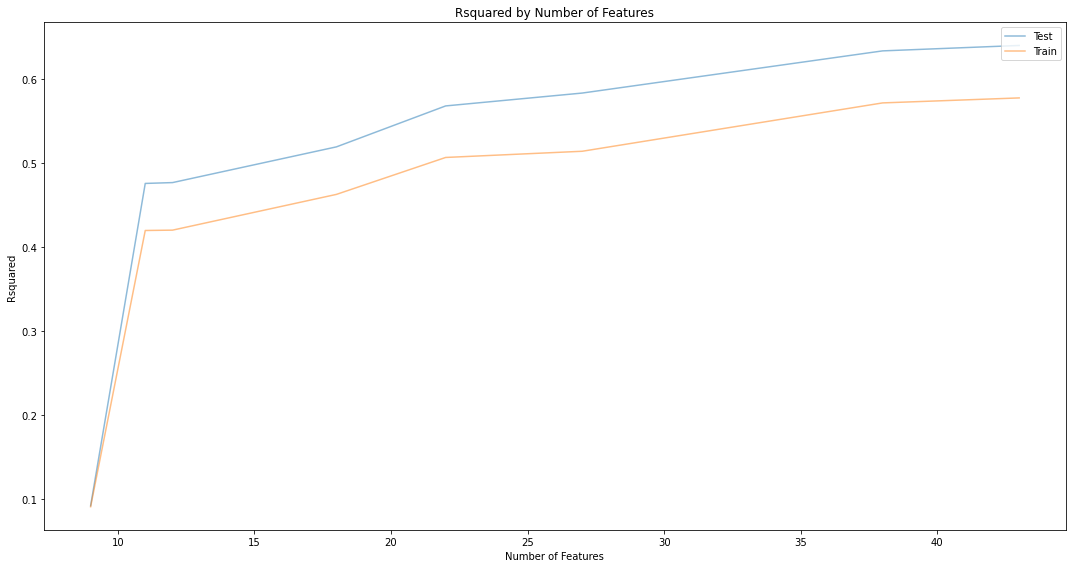

In [151]:
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [152]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2


43
0.6399958289012757
0.5775189129129368


In [153]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
pd.options.display.float_format = '{:.2f}'.format
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(43)

,est_int,coefs,abs_coefs
35,bedrooms_0.0,-163.47,163.47
36,bedrooms_1.0,-125.41,125.41
30,room_type_Entire home/apt,78.46,78.46
37,bedrooms_2.0,-73.67,73.67
19,neighbourhood_Jamaica Plain,-64.32,64.32
24,neighbourhood_cleansed_Jamaica Plain,48.83,48.83
41,bathrooms_1.0,-38.43,38.43
15,neighbourhood_Allston-Brighton,-37.01,37.01
13,zipcode_02118,34.05,34.05
22,neighbourhood_cleansed_Back Bay,32.26,32.26


In [154]:
coef_df['Price Impact'] = coef_df.coefs

In [155]:
coef_df['Attribute'] = coef_df.est_int

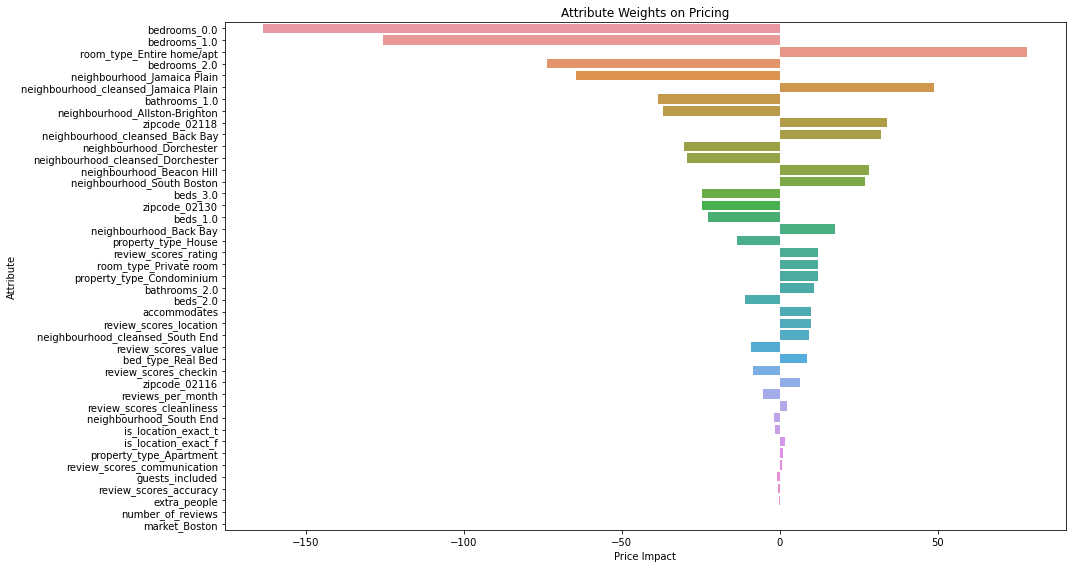

In [156]:
sns.barplot(x='Price Impact', y='Attribute', data=coef_df);
plt.title('Attribute Weights on Pricing');

# Analysis

Predict Price of Airbnb rentals.

The idea is to help new Airbnb host with listing their properties at a competitive price that will result in consistant bookings. 

- Does location determine how much a airbnb rental is listed for?
- Can the size (number of bedrooms, bathrooms, and bed) influnece higher price?
- Does higher review scores drive pricing?


## Predictions

### Location 
- Airbnbs in Jamaica Plains are lower in price unless it is cleansed then the price is higher.
- Neighborhoods with cheaper airbnb properties:
    - Allston-Brighton
    - Dorchester
    - zipcode 02130
    - South End
- Neighborhood with more expensive airbnb properties:
    - Beacon Hill
    - South Boston
    - Back Bay
    - zipcode 02116 
- Review score on location also leads to increased price

### Size
- Renting a house will have a lower price while its the opposite for a condo and apartment.
- Renting the entire house or just a private room both increase the price
- Number of beds, bedrooms, and bathrooms will have an influence on pricing
    - 0-2 bedrooms lower the price
    - 1 bathroom has a negative effect on pricing
    - 2 bathrooms increase the pricing
    - 3 beds lower the price more than 1-2 beds
    - Real beds increase the price
- How many an airbnb can accommodate will increase the price

### Reviews
- Host review ratings score and review location scores will have a positive influence on pricing
- Review score values and review score check-in has a negative influence on pricing
- Review score of cleanliness and communication will raise the prices. 

